# NNDL Final Project

## Team Members:
### 1. Aniket Sakharkar
### 2. Jwalit Shah
### 3. Aarushi Sharma

Importing necessary libraries

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 18 09:52:31 2023

@author: aarushisharma
"""

# Importing the necessary libraries

import os
import pandas as pd
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping, Callback


Getting the datasets from the desired directory

In [14]:
# Loading the Pneumonia Dataset - training, test, and validation dataset
file_paths = [os.path.join(dirname, filename)
              for dirname, _, filenames in os.walk('/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray')
              for filename in filenames]

for path in file_paths:
    print(path)

/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/.DS_Store
/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg
/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg
/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg
/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg
/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test/PNEUMONIA/person1647_virus_2848.jpeg
/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test/PNEUMONIA/person1675_virus_2891.jpeg
/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test/PNEUMONIA/person89_bacteria_440.jpeg
/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test/PNEUMONIA/person35_vir

Seting up labels and size of the image

In [15]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

Preprocessing the train dataset

In [16]:
def train_import(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


## Load the data from the directory
train = train_import('/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/train')
test = train_import('/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test')
val = train_import('/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/val')



/var/folders/7p/l8cmrz3s0gx_7tcygpqfmtkc0000gn/T/ipykernel_56243/1830877283.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


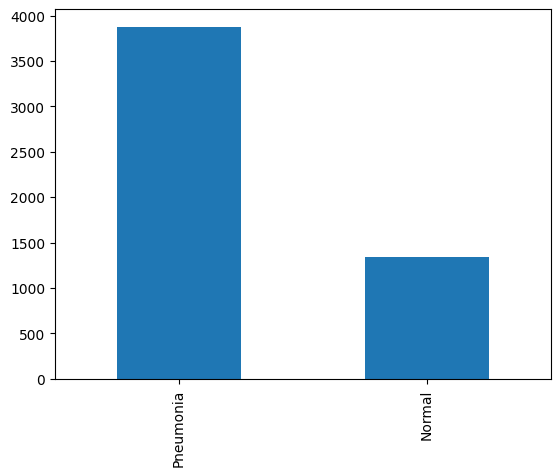

Text(0.5, 1.0, 'NORMAL')

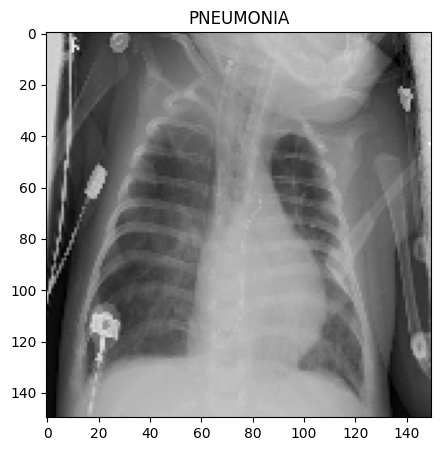

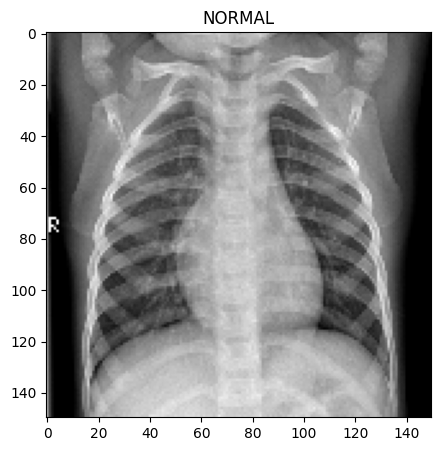

In [17]:



## Exploratory Data Analysis of the original dataset before data transformation
train_labels = []
[train_labels.append("Pneumonia") if label == 0 else train_labels.append("Normal") for _, label in train]
train_labels_series = pd.Series(train_labels)
label_counts = train_labels_series.value_counts()
label_counts.plot.bar()
plt.show()


plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])


In [18]:

    
# Separate features and labels for the training, validation, and test sets
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Convert data to numpy arrays and normalize the pixel values to [0, 1]
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)



Data Augmentation: We must artificially enlarge our dataset to prevent the overfitting issue. We can 
    increase the size of the dataset you already have. The goal is to replicate the variations by making modest 
    adjustments to the training data. Data augmentation strategies are methods that modify the training data 
    in a way that modifies the array representation while preserving the label. Grayscales, vertical and 
    horizontal flips, random cropping, color hiccups, translations, rotations, and many other augmentations 
    are frequently used. We can easily double or quadruple the number of training examples and build a very 
    robust model by applying only a few of these adjustments to our training data.

Data Augmentation Steps:

1. 30 degree random rotation of certain training photos
2. Randomly 20% zoom few practice pictures
3. Images should be randomly moved horizontally by 10% of their width.
4. photos at random by 10% of the height vertically
5. Flip pictures horizontally at random. Upon completion, we fit the training dataset to our model.


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255, shear_range = 0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,
    vertical_flip=False
    )
test_datagen = ImageDataGenerator(rescale=1./255)

# =============================================================================
# 
# train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1./255)
# 
# =============================================================================
# Set directories for training, validation and test datasets


In [20]:
train_dir = '/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/train'
validation_dir = '/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/val'
test_dir = '/Users/aarushisharma/Documents/NEU/NEU_Course/Spring_2023/NNDL/chest_xray/test'


# Set up the generators for the training, validation and test datasets

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=batch_size, class_mode='binary')



# =============================================================================
# 
# class_indices = train_generator.class_indices
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
# class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))
# 
# =============================================================================



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Training the model on train dataset for different combinations of Epochs, Learning Rate, and Batch Size to get the 
best model

Epoch 1/12
163/163 [==============================] - 83s 508ms/step - loss: 0.4422 - accuracy: 0.8150 - val_loss: 1.6394 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 2/12
163/163 [==============================] - 80s 492ms/step - loss: 0.3092 - accuracy: 0.8725 - val_loss: 3.5812 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 3/12
163/163 [==============================] - 80s 491ms/step - loss: 0.2615 - accuracy: 0.8825 - val_loss: 3.2106 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 4/12
163/163 [==============================] - 88s 538ms/step - loss: 0.2438 - accuracy: 0.9013 - val_loss: 1.3937 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 5/12
163/163 [==============================] - 81s 495ms/step - loss: 0.2286 - accuracy: 0.8997 - val_loss: 0.9615 - val_accuracy: 0.6875 - lr: 1.0000e-05
Epoch 6/12
163/163 [==============================] - 80s 491ms/step - loss: 0.2276 - accuracy: 0.9039 - val_loss: 0.9193 - val_accuracy: 0.6875 - lr: 1.0000e-05
Epoch 7/12
163/163 [========

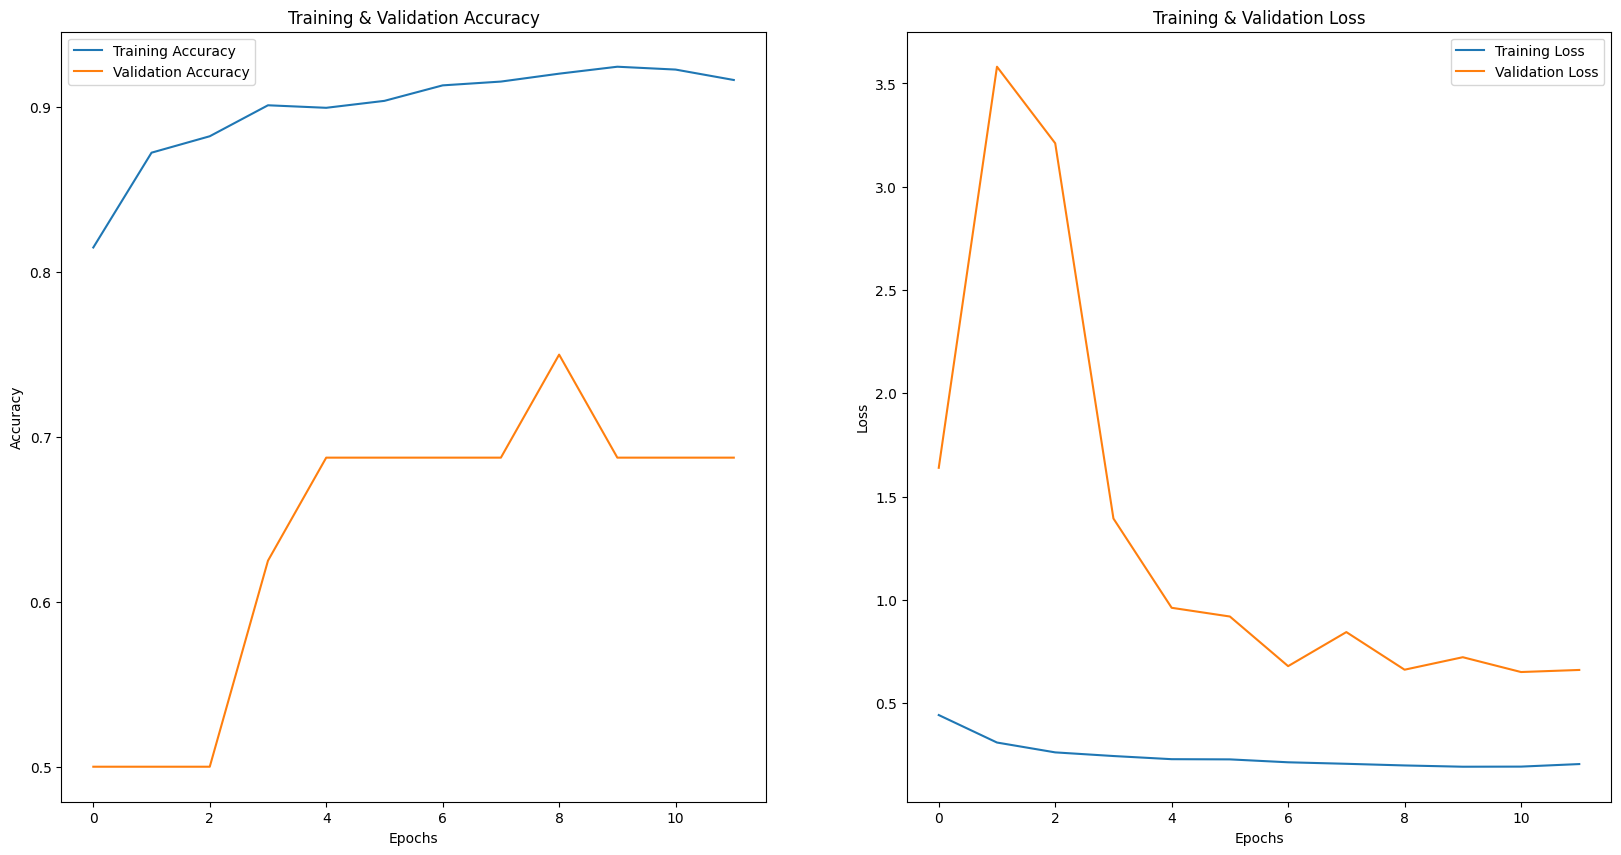

20/20 [==============================] - 4s 199ms/step - loss: 0.2827 - accuracy: 0.8878
Test accuracy: 0.8878205418586731
Epoch 1/12
163/163 [==============================] - 82s 496ms/step - loss: 0.9423 - accuracy: 0.5970 - val_loss: 0.6907 - val_accuracy: 0.5625 - lr: 1.0000e-06
Epoch 2/12
163/163 [==============================] - 81s 493ms/step - loss: 0.6377 - accuracy: 0.7285 - val_loss: 1.0035 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 3/12
163/163 [==============================] - 81s 493ms/step - loss: 0.5223 - accuracy: 0.7805 - val_loss: 1.1797 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 4/12
163/163 [==============================] - 81s 493ms/step - loss: 0.4425 - accuracy: 0.8085 - val_loss: 0.9251 - val_accuracy: 0.5625 - lr: 1.0000e-06
Epoch 5/12
163/163 [==============================] - 81s 496ms/step - loss: 0.4234 - accuracy: 0.8209 - val_loss: 0.7436 - val_accuracy: 0.6875 - lr: 1.0000e-06
Epoch 6/12
163/163 [==============================] - 201s 1s/step 

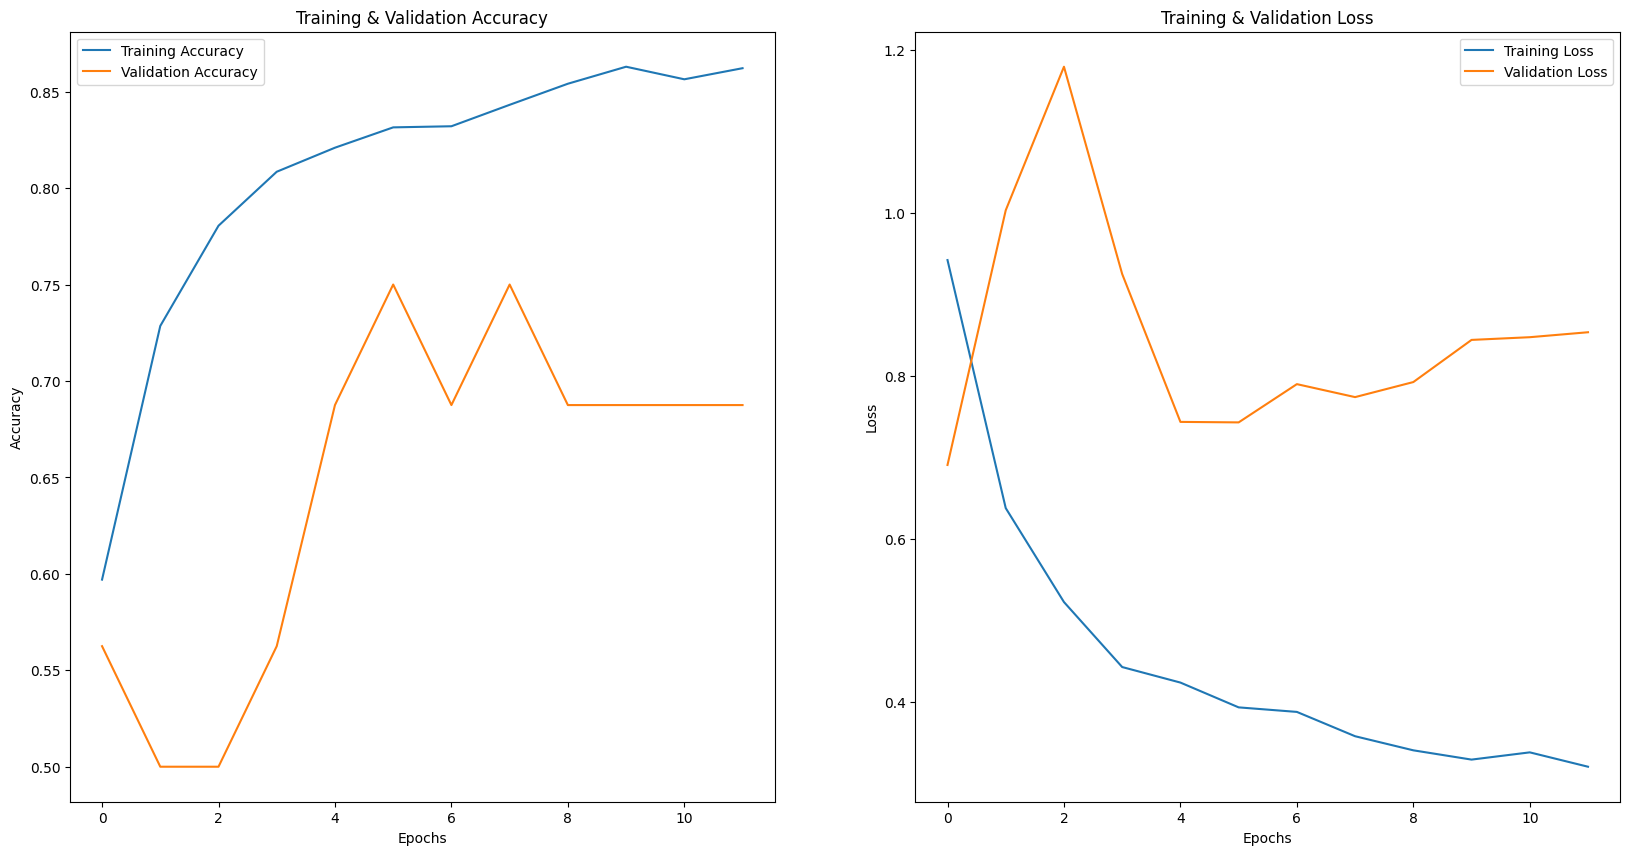

20/20 [==============================] - 4s 203ms/step - loss: 0.3010 - accuracy: 0.8798
Test accuracy: 0.879807710647583
Epoch 1/12
163/163 [==============================] - 83s 503ms/step - loss: 0.4880 - accuracy: 0.8083 - val_loss: 2.0209 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 2/12
163/163 [==============================] - 81s 497ms/step - loss: 0.3258 - accuracy: 0.8629 - val_loss: 3.3602 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 3/12
163/163 [==============================] - 81s 495ms/step - loss: 0.2646 - accuracy: 0.8867 - val_loss: 2.4911 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 4/12
163/163 [==============================] - 81s 498ms/step - loss: 0.2505 - accuracy: 0.8911 - val_loss: 1.1304 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 5/12
163/163 [==============================] - 80s 491ms/step - loss: 0.2341 - accuracy: 0.9066 - val_loss: 0.8656 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 6/12
163/163 [==============================] - 81s 493ms/step

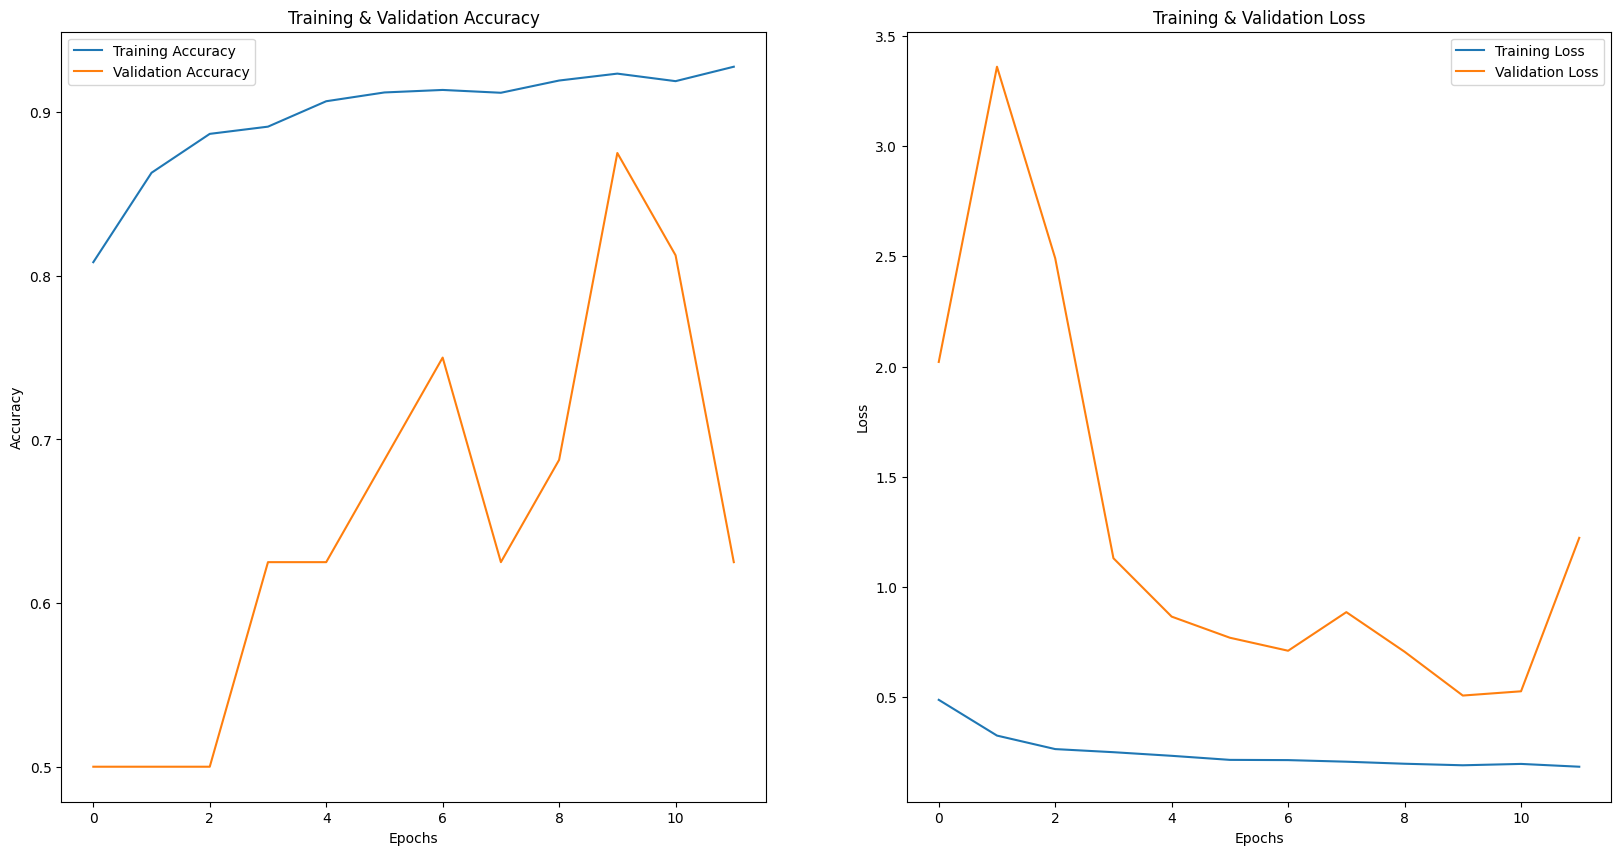

20/20 [==============================] - 4s 196ms/step - loss: 0.3581 - accuracy: 0.8750
Test accuracy: 0.875
Epoch 1/15
163/163 [==============================] - 84s 509ms/step - loss: 0.8467 - accuracy: 0.6308 - val_loss: 0.9916 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 2/15
163/163 [==============================] - 81s 495ms/step - loss: 0.5828 - accuracy: 0.7510 - val_loss: 1.7556 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 3/15
163/163 [==============================] - 80s 487ms/step - loss: 0.5068 - accuracy: 0.7889 - val_loss: 1.8145 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 4/15
163/163 [==============================] - 80s 487ms/step - loss: 0.4323 - accuracy: 0.8163 - val_loss: 1.0108 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 5/15
163/163 [==============================] - 80s 489ms/step - loss: 0.4146 - accuracy: 0.8261 - val_loss: 0.7600 - val_accuracy: 0.6875 - lr: 1.0000e-06
Epoch 6/15
163/163 [==============================] - 82s 502ms/step - loss: 0.3

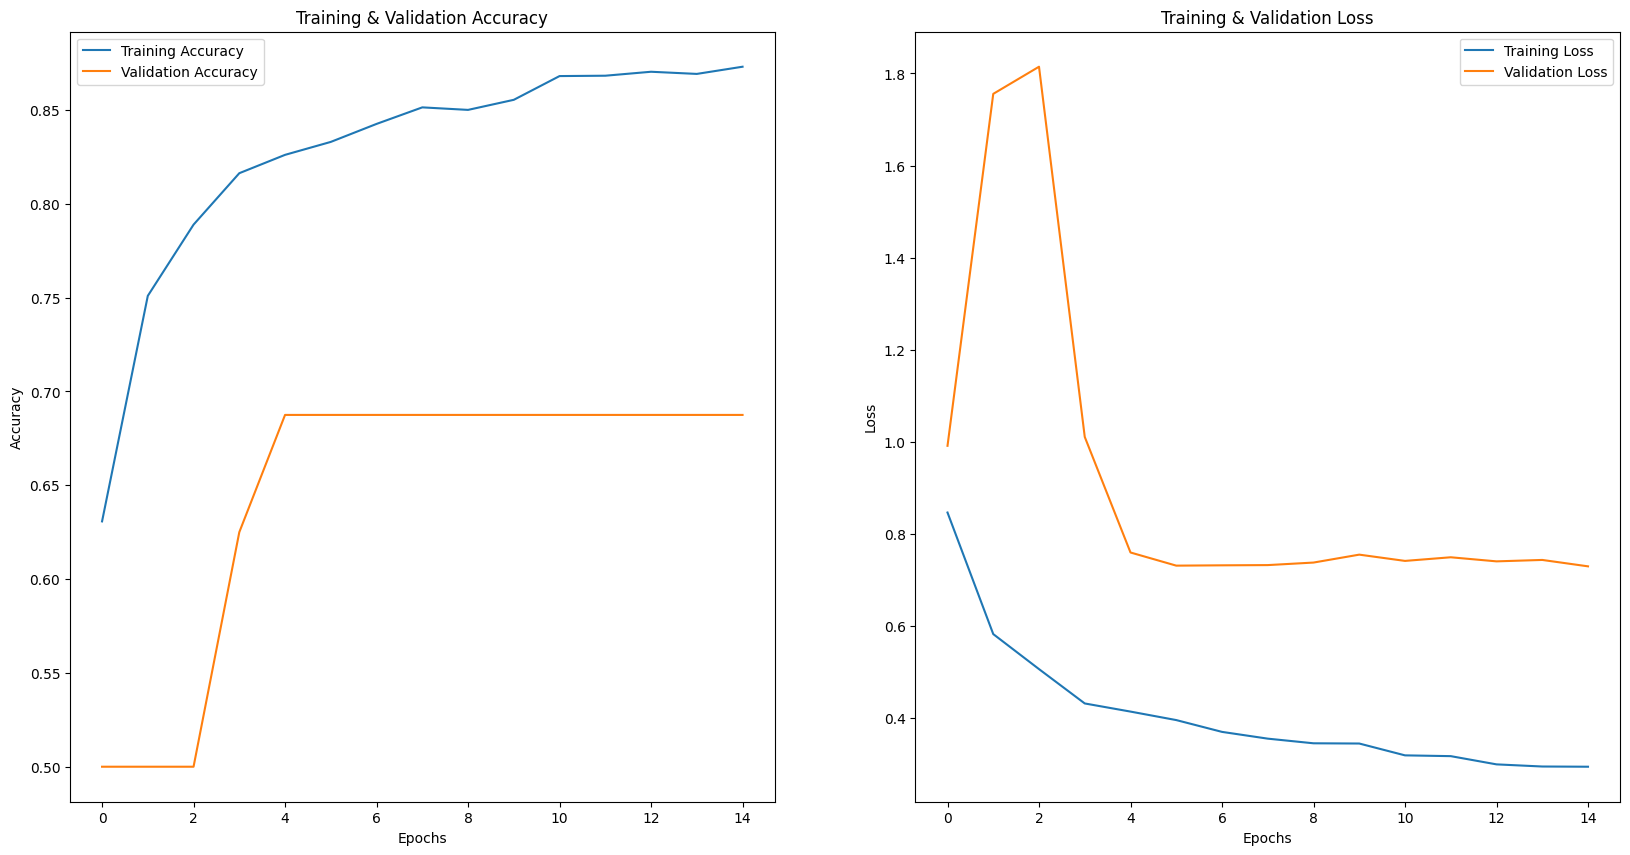

20/20 [==============================] - 4s 208ms/step - loss: 0.3978 - accuracy: 0.8269
Test accuracy: 0.8269230723381042
Epoch 1/15
163/163 [==============================] - 86s 522ms/step - loss: 0.4548 - accuracy: 0.8033 - val_loss: 1.9486 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 2/15
163/163 [==============================] - 84s 516ms/step - loss: 0.2924 - accuracy: 0.8740 - val_loss: 3.4360 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 3/15
163/163 [==============================] - 84s 513ms/step - loss: 0.2598 - accuracy: 0.8932 - val_loss: 3.1477 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 4/15
163/163 [==============================] - 84s 513ms/step - loss: 0.2401 - accuracy: 0.8969 - val_loss: 1.6803 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 5/15
163/163 [==============================] - 86s 528ms/step - loss: 0.2155 - accuracy: 0.9141 - val_loss: 0.9221 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 6/15
163/163 [==============================] - 85s 518ms/ste

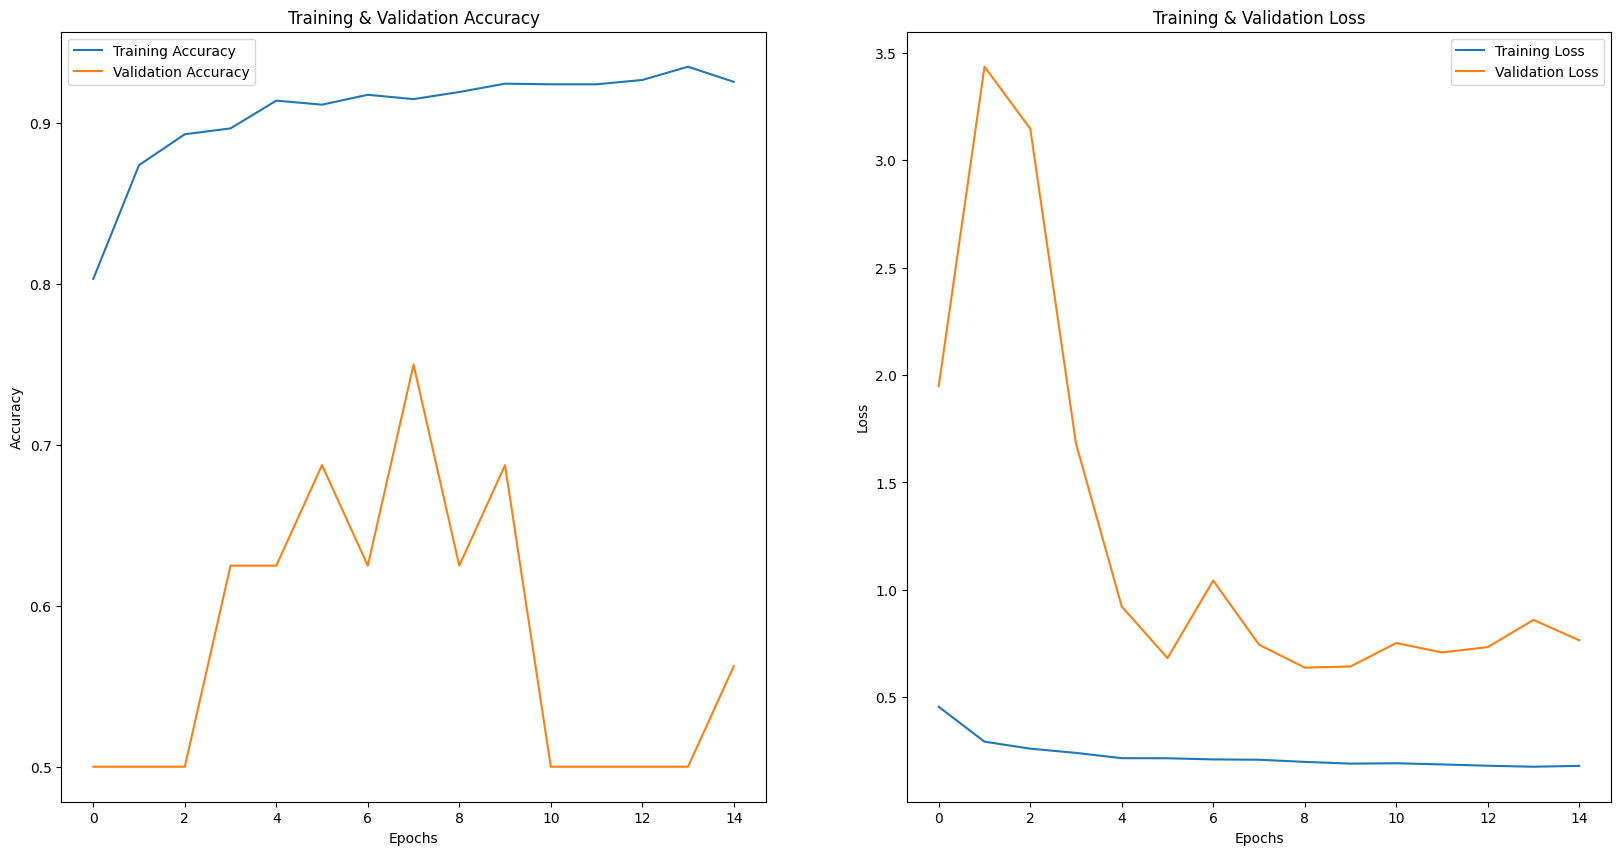

20/20 [==============================] - 4s 198ms/step - loss: 0.2859 - accuracy: 0.8926
Test accuracy: 0.8926281929016113
   Batch Size  Epochs  Learning Rate  Precision    Recall  Accuracy
0          32      12       0.000001   0.635492  0.679487  0.556090
1          32      12       0.000010   0.643172  0.748718  0.583333
2          32      15       0.000001   0.610119  0.525641  0.493590
3          32      15       0.000010   0.622829  0.643590  0.533654


In [21]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score


# Defining plots

def plot_history(history, epochs):
    epochs_range = range(epochs)
    fig, ax = plt.subplots(1,2, figsize=(20, 10))
    ax[0].plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs_range, history.history['loss'], label='Training Loss')
    ax[1].plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    plt.show()




# Define a function to train and evaluate the model
def train_and_evaluate_model(batch_size, epochs, lr):

    # Defining the model architecture
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid'))

    
    # Compile the model with chosen optimizer, loss function and evaluation metric
    model.compile(optimizer = Adam(learning_rate = lr), loss='binary_crossentropy', metrics=['accuracy'])


    
    # Define the callbacks
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.3, min_lr=0.000001)


    
    # Fit the model to the data with callback
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks = [learning_rate_reduction])

    plot_history(history, epochs)
    

    
    # Predict on the test data
    y_pred = model.predict(test_generator)
    y_pred = (y_pred > 0.5).astype(int)
    
    
    # Evaluate the model on the test dataset
    test_loss, test_acc = model.evaluate(test_generator)
    print('Test accuracy:', test_acc)
    
    
    # Calculate the precision, recall, and accuracy
    precision = precision_score(test_generator.classes, y_pred)
    recall = recall_score(test_generator.classes, y_pred)
    accuracy = accuracy_score(test_generator.classes, y_pred)
    
    return precision, recall, accuracy



# Define the hyperparameters to test

batch_sizes = 32
epochs_list = [12, 15]
learning_rates = [0.000001, 0.00001]

train_and_evaluate_model(batch_size, epochs, lr)



# Create a list to store the results

results = []


# Iterate through the hyperparameters and train the model

for epochs in epochs_list:
    for lr in learning_rates:
        
        # Train and evaluate the model
        precision, recall, accuracy = train_and_evaluate_model(batch_size, epochs, lr)
        
        # Store the results in a dictionary
        result = {'Batch Size': batch_size, 'Epochs': epochs, 'Learning Rate': lr, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}
        results.append(result)

# Create a dataframe to store the results
results_df = pd.DataFrame(results)

# Display the results in a table
print(results_df)



Compile and train the model with chosen optimizer, loss function and evaluation metric of the best combination
of epochs, batch size, and learning rate

In [23]:
# Defining the model architecture
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))


# Compile the model with chosen optimizer, loss function and evaluation metric
model.compile(optimizer = Adam(learning_rate = 0.00001), loss='binary_crossentropy', metrics=['accuracy'])



train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size = 32, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size = 32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size = 32, class_mode='binary')


# Define the callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.3, min_lr=0.000001)


# Fit the model to the data with callback
history = model.fit(train_generator, epochs = 10, validation_data = validation_generator, callbacks = [learning_rate_reduction])


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 84s 509ms/step - loss: 0.4896 - accuracy: 0.7952 - val_loss: 2.3206 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 2/10
163/163 [==============================] - 82s 503ms/step - loss: 0.3202 - accuracy: 0.8576 - val_loss: 4.1307 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 3/10
163/163 [==============================] - 81s 492ms/step - loss: 0.2736 - accuracy: 0.8811 - val_loss: 3.0445 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 4/10
163/163 [==============================] - 80s 489ms/step - loss: 0.2578 - accuracy: 0.8873 - val_loss: 1.5512 - val_accuracy: 0.6250 - lr: 1.0000e-05
Epoch 5/10
163/163 [==============================] - 83s 508ms/step - loss: 0.2423 - accuracy: 0.8951 - val_loss: 1.0275 - val_accuracy: 0.6875 - lr: 1.0000e-05
Epoch 6/10
163/163 [==============================] - 83s 509ms/ste

Predicting the model using the test dataset and displaying the confusion matrix of the predictions

20/20 [==============================] - 4s 197ms/step - loss: 0.3089 - accuracy: 0.8926
Test accuracy: 0.8926281929016113
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

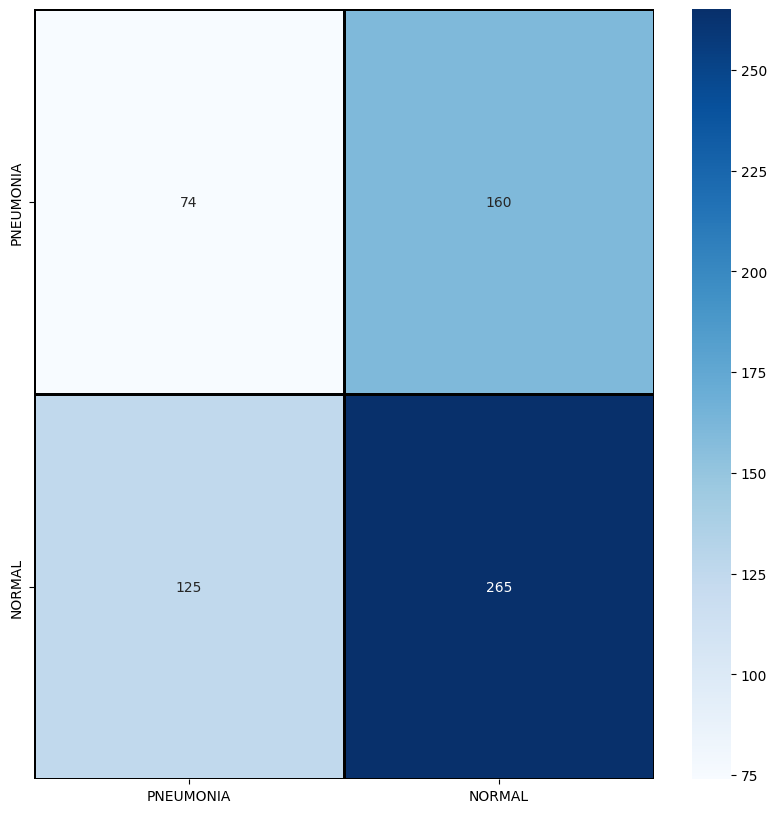

In [24]:

# Predict on the test data
y_pred = model.predict(test_generator).reshape(1, -1)[0]
y_pred = (y_pred > 0.5).astype(int)


# Evaluate the model on the test dataset
print(test_labels)

# Generate the confusion matrix
conf_mat = confusion_matrix(test_labels, y_pred)
print(conf_mat)


conf_mat = pd.DataFrame(conf_mat , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)


print(classification_report(test_labels, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))


Images of incorrect predictions and correct predictions

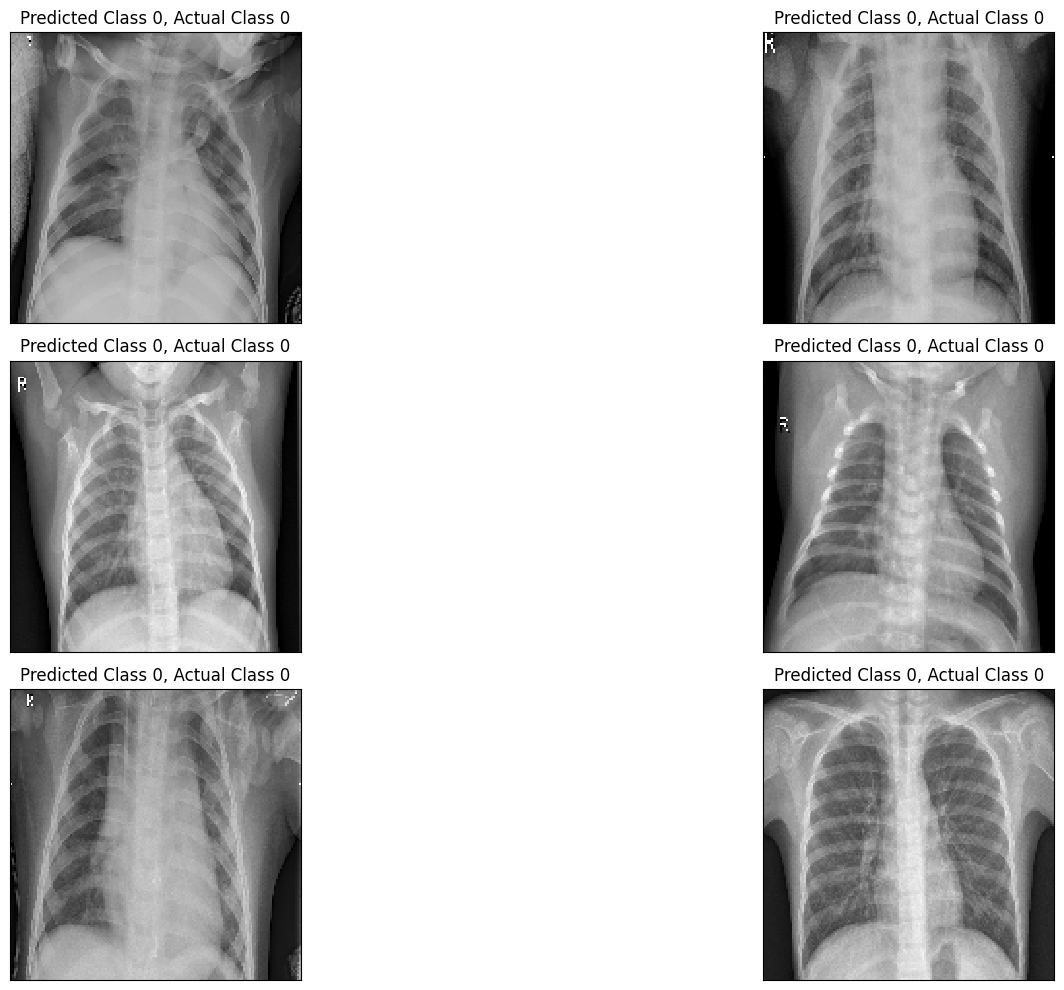

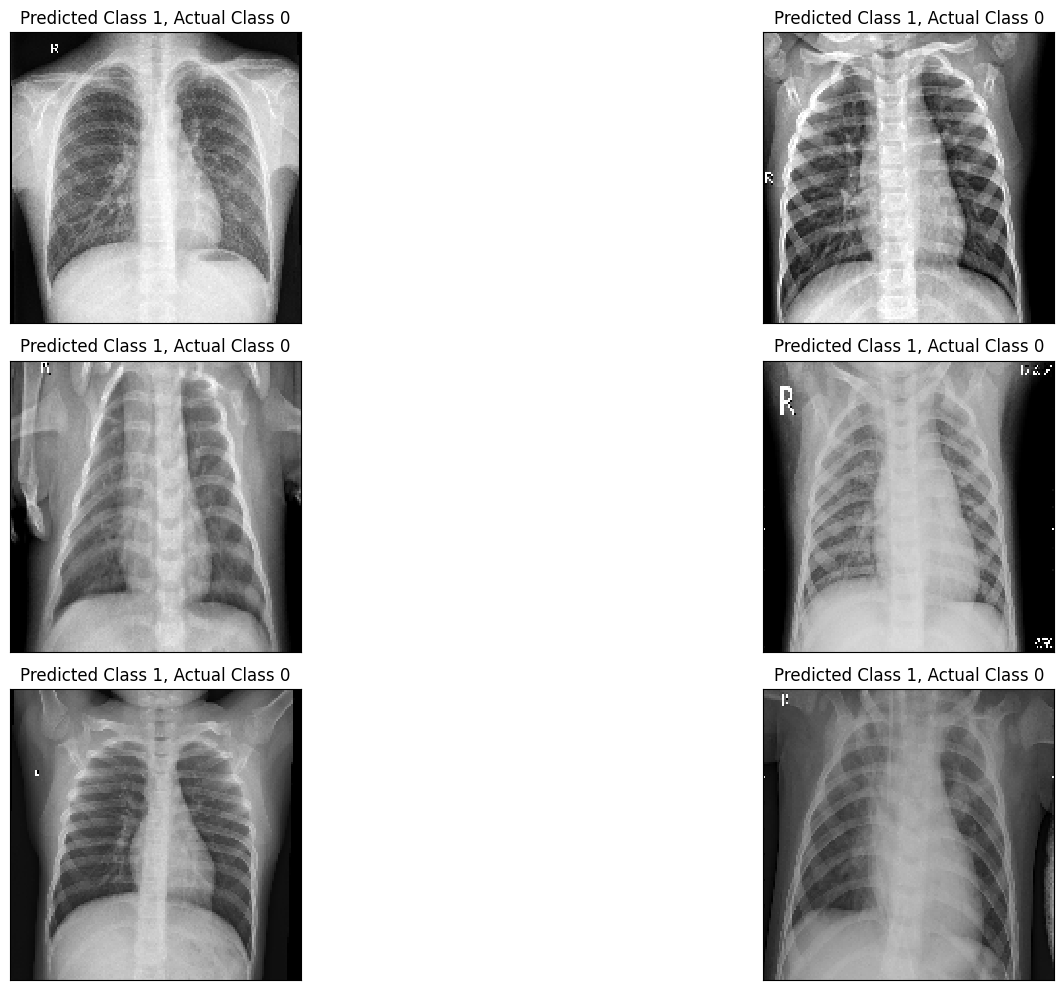

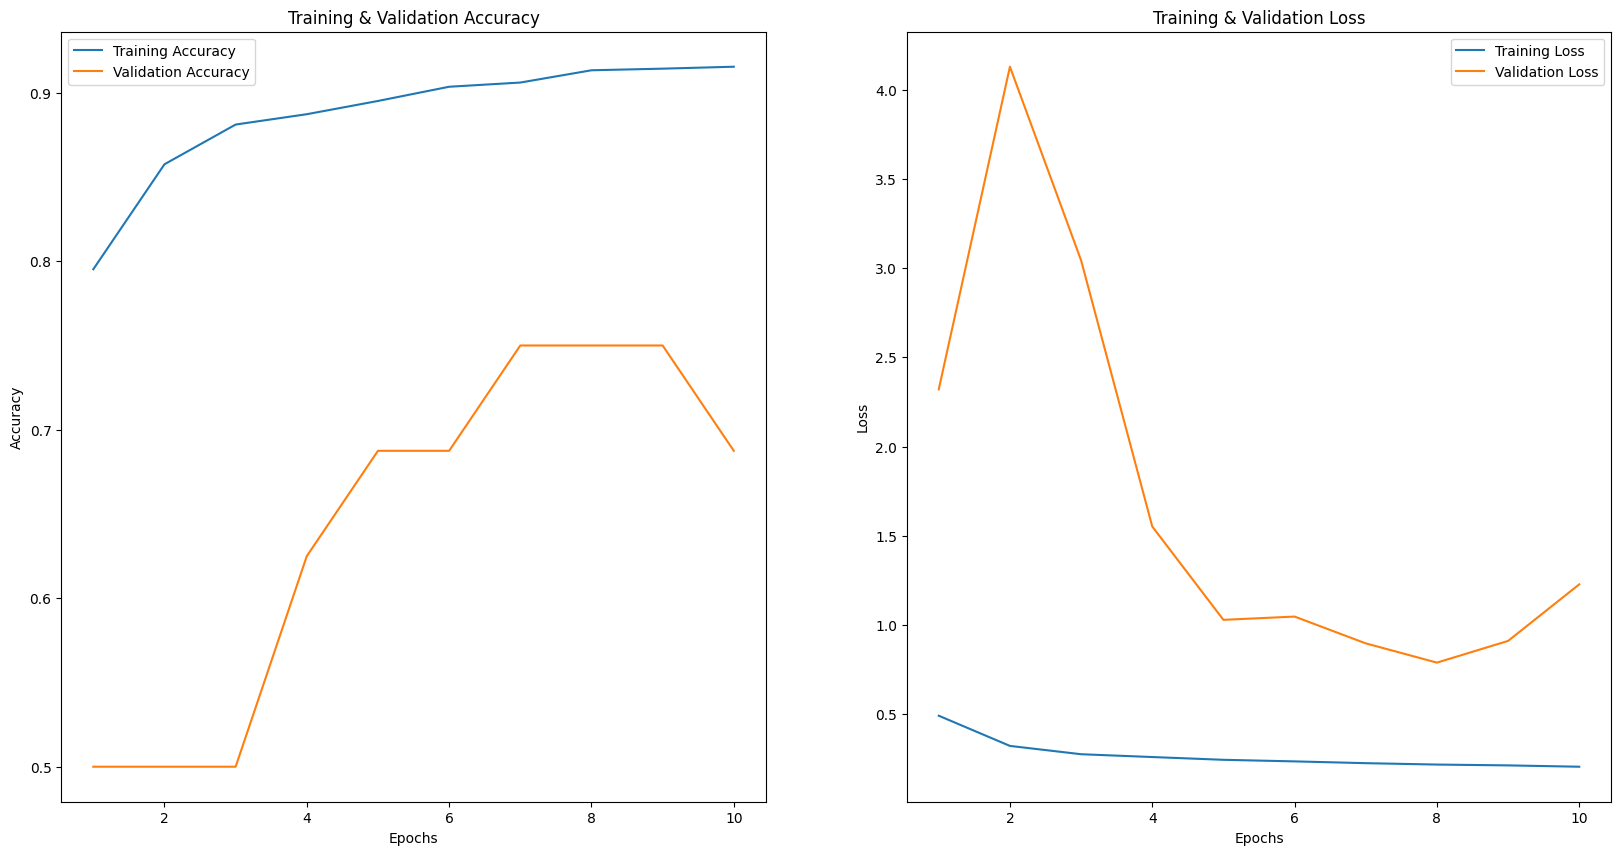

In [26]:

correct = np.where(test_labels == y_pred)[0]
# =============================================================================
# print(correct)
# =============================================================================
incorrect = np.where(test_labels != y_pred)[0]
# =============================================================================
# print(incorrect)
# =============================================================================


# Plot a few correctly predicted images of the best combination model

i = 0
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
for c, ax in zip(correct[:6], axes.flatten()):
    img, label = next(test_generator)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img[0], cmap="gray", interpolation='none')
    ax.set_title("Predicted Class {}, Actual Class {}".format(y_pred[c], test_labels[c]))
    i += 1

# Remove any overlapping axes
for ax in axes.flatten()[i:]:
    ax.remove()
    
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3, 2, figsize=(20, 10))
for c, ax in zip(incorrect[:6], axes.flatten()):
    img, label = next(test_generator)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img[0], cmap="gray", interpolation='none')
    ax.set_title("Predicted Class {}, Actual Class {}".format(y_pred[c], test_labels[c]))
    i += 1

# Remove any overlapping axes
for ax in axes.flatten()[i:]:
    ax.remove()
    
plt.tight_layout()
plt.show()




epochs_range = range(1,11)
fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
ax[0].plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs_range, history.history['loss'], label='Training Loss')
ax[1].plot(epochs_range, history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()
